In [594]:
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle

In [595]:
# Define transformation for training (with augmentation) and testing (no augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
# test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
with open('b1.pkl', 'rb') as b1:
  test_dataset = pickle.load(b1)



In [596]:
def preprocessing(dataset):
    data, labels = zip(*dataset)  # Unpacking the data and labels
    
    data = np.array(data).reshape((-1, 28*28)).astype(np.float32)
    
    data /= 255.0
    
    labels = np.array(labels)
    classes = len(np.unique(labels))  # Number of unique classes
    
    labels = np.clip(labels, 0, classes-1)
    
    # One-hot encoding of the labels
    labels = np.eye(classes)[labels]
    
    return data, labels

test_data, test_labels = preprocessing(test_dataset)
print(test_data.shape, test_labels.shape)

train_data,train_labels = preprocessing(train_dataset)
print(train_data.shape, train_labels.shape)

test_labels = np.argmax(test_labels, axis=1)  # Assuming labels_test are one-hot encoded
expanded_test_labels = np.zeros((test_labels.shape[0], 10))  # Create a 10-class one-hot array

# Assign the existing 4 classes to the first 4 columns (or wherever appropriate)
expanded_test_labels[np.arange(test_labels.shape[0]), test_labels] = 1

print(expanded_test_labels.shape)




(3611, 784) (3611, 4)
(60000, 784) (60000, 10)
(3611, 10)


In [597]:
class BaseLayer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        raise NotImplementedError()
    
    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError()
    
def xavier_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(2.0 / (input_size + output_size))


In [598]:
class AdamOptimizer:
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-6):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.mb = None
        self.vw = None
        self.vb = None
        self.t = 0
        
    def update(self, weights, biases, weights_gradient, biases_gradient, learning_rate):
        self.t += 1
        # print(self.t)
        if self.mw is None:
            self.mw = np.zeros_like(weights)
            self.mb = np.zeros_like(biases)
            self.vw = np.zeros_like(weights)
            self.vb = np.zeros_like(biases)
        self.mw = self.beta1 * self.mw + (1 - self.beta1) * weights_gradient
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * biases_gradient
        self.vw = self.beta2 * self.vw + (1 - self.beta2) * np.power(weights_gradient, 2)
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * np.power(biases_gradient, 2)
        mw_hat = self.mw / (1 - np.power(self.beta1, self.t))
        mb_hat = self.mb / (1 - np.power(self.beta1, self.t))
        vw_hat = self.vw / (1 - np.power(self.beta2, self.t))
        vb_hat = self.vb / (1 - np.power(self.beta2, self.t))
        weights -= learning_rate * mw_hat / (np.sqrt(vw_hat) + self.epsilon)
        biases -= learning_rate * mb_hat / (np.sqrt(vb_hat) + self.epsilon)
        

In [599]:
class DenseLayer(BaseLayer):
    def __init__(self, input_size, output_size, initializer=xavier_initialization, optimizer=AdamOptimizer):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = initializer(self.input_size, self.output_size)
        self.biases = initializer(1, self.output_size)
        self.optimizer = optimizer()
        
    def forward(self, input):
        self.input = input
        # y = xW+b
        self.output = np.dot(self.input, self.weights) + self.biases
        return self.output 

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(output_gradient, self.weights.T)
        weights_gradient = np.dot(self.input.T, output_gradient)
        biases_gradient = np.sum(output_gradient, axis=0)
        self.optimizer.update(self.weights, self.biases, weights_gradient, biases_gradient, learning_rate)
        
        return input_gradient


In [600]:
class BatchNormalizationLayer(BaseLayer):
    def __init__(self, input_size, momentum=0.9, epsilon=1e-8):
        # Parameters
        self.gamma = np.ones((1, input_size))  # Scale parameter (initialized to 1)
        self.beta = np.zeros((1, input_size))  # Shift parameter (initialized to 0)
        self.momentum = momentum  # Momentum for running mean and variance
        self.epsilon = epsilon  # Small constant to avoid division by zero

        # Moving averages of mean and variance (used during inference)
        self.running_mean = np.zeros((1, input_size))
        self.running_variance = np.zeros((1, input_size))
    
    def forward(self, input, training=True):
        self.input = input
        
        if training:
            # Compute mean and variance for the current batch
            self.batch_mean = np.mean(self.input, axis=0, keepdims=True)
            self.batch_variance = np.var(self.input, axis=0, keepdims=True)

            # Normalize the batch
            self.x_hat = (self.input - self.batch_mean) / np.sqrt(self.batch_variance + self.epsilon)

            # Update running mean and variance (exponentially weighted average)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_variance = self.momentum * self.running_variance + (1 - self.momentum) * self.batch_variance
        else:
            # Use the running mean and variance during inference
            self.x_hat = (self.input - self.running_mean) / np.sqrt(self.running_variance + self.epsilon)

        # Scale and shift the normalized data
        self.output = self.gamma * self.x_hat + self.beta
        
        return self.output

    def backward(self, output_gradient, learning_rate):
        #inputs in the batch
        m = self.input.shape[0]

        # Gradients w.r.t. gamma and beta
        gamma_gradient = np.sum(output_gradient * self.x_hat, axis=0, keepdims=True)
        beta_gradient = np.sum(output_gradient, axis=0, keepdims=True)

        # Gradient of the loss w.r.t. the normalized input (x_hat)
        dx_hat = output_gradient * self.gamma

        # Gradients w.r.t. the batch mean and variance
        dvariance = np.sum(dx_hat * (self.input - self.batch_mean) * -0.5 * np.power(self.batch_variance + self.epsilon, -1.5), axis=0, keepdims=True)
        dmean = np.sum(dx_hat * -1 / np.sqrt(self.batch_variance + self.epsilon), axis=0, keepdims=True) + dvariance * np.mean(-2 * (self.input - self.batch_mean), axis=0, keepdims=True)

        # Gradient of the input
        input_gradient = dx_hat / np.sqrt(self.batch_variance + self.epsilon) + dvariance * 2 * (self.input - self.batch_mean) / m + dmean / m

        # Update gamma and beta
        self.gamma -= learning_rate * gamma_gradient
        self.beta -= learning_rate * beta_gradient

        return input_gradient


In [601]:
class ActivationFunction(BaseLayer):
    def __init__(self, activation, derivative):
        self.activation = activation
        self.derivative = derivative
        
    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = np.multiply(output_gradient, self.derivative(self.input))
        return input_gradient
    

In [602]:
class ReLU(ActivationFunction):
    def __init__(self):
        super().__init__(self.relu, self.relu_derivative)
        
    def relu(self, x):
        return np.maximum(0, x) # ReLU = max(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0) # Derivative of ReLU = 1 if x > 0, 0 otherwise

In [603]:
class DropoutLayer:    
    def __init__(self, dropout_prob):
        self.dropout = dropout_prob
        self.mask = None
        
    def forward(self, input):
        self.input = input
        if self.dropout == 0:
            self.output = self.input
            return self.output
        elif self.dropout == 1:
            self.output = np.zeros(self.input.shape)
            return self.output
        self.mask = (np.random.rand(*self.input.shape) > self.dropout).astype(float)
        self.output = np.multiply(self.input, self.mask) / (1 - self.dropout)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = np.multiply(output_gradient, self.mask) / (1 - self.dropout)
        return input_gradient

In [604]:
def softmax(x):
    expo = np.exp(x - np.max(x, axis=1, keepdims=True))
    expsum = np.sum(expo, axis=1, keepdims=True)
    return expo / expsum
class Softmax(ActivationFunction):
    def __init__(self): 
        super().__init__(softmax, self.return_ones)
        
    def return_ones(self, x): # Derivative of softmax is 1
        return np.ones(x.shape)

In [605]:
class CrossEntropyLoss:
    def error(self, y_true, y_pred):
        
        assert y_true.shape == y_pred.shape, "Shape mismatch between y_true and y_pred"
        
        
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(np.multiply(y_true, np.log(y_pred)))
    
    def error_derivative(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return y_pred - y_true

In [606]:
class FNN:
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, input):
        output = input
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = output_gradient
        for layer in reversed(self.layers):
            input_gradient = layer.backward(input_gradient, learning_rate)
        return input_gradient
    
    

    def train(self, Loss, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        self.loss = Loss
        epoch_loss = []
        epoch_val_loss = []
        epoch_train_acc = []
        epoch_val_acc = []
        epoch_val_f1 = []

        for epoch in tqdm(range(epochs)):
            train_loss = 0
            train_correct = 0
            val_correct = 0
        
            # Training phase
            for j in range(0, len(X_train), batch_size):
                X_batch = X_train[j:j+batch_size]
                y_logits = y_train[j:j+batch_size]
                y_prediction = self.forward(X_batch)
            
                train_loss += self.loss.error(y_logits, y_prediction)
                y_batch_size = y_logits.shape[0]
            
                # If last layer is Softmax, compute the gradient for backward propagation
                if isinstance(self.layers[-1], Softmax):
                    output_gradient = (y_prediction - y_logits) / y_batch_size
                output_gradient = self.backward(output_gradient, learning_rate)
            
                # Calculate training accuracy for this batch
                predicted_classes = np.argmax(y_prediction, axis=1)
                true_classes = np.argmax(y_logits, axis=1)
                train_correct += np.sum(predicted_classes == true_classes)
        
            # Average training loss over all batches
            avg_train_loss = train_loss / (len(X_train) / batch_size)
            epoch_loss.append(avg_train_loss)

            # Calculate training accuracy for the epoch
            train_accuracy = 100 * train_correct / len(X_train)
            epoch_train_acc.append(train_accuracy)

            # Validation phase
            val_loss = 0
            y_val_pred = []
            y_val_true = []
        
            for k in range(0, len(X_val), batch_size):
                X_val_batch = X_val[k:k+batch_size]
                y_val_logits = y_val[k:k+batch_size]
                y_val_pred_batch = self.forward(X_val_batch)
            
                val_loss += self.loss.error(y_val_logits, y_val_pred_batch)
                predicted_classes = np.argmax(y_val_pred_batch, axis=1)
                true_classes = np.argmax(y_val_logits, axis=1)
                val_correct += np.sum(predicted_classes == true_classes)
            
                # Collect predictions and ground truths for F1 score calculation
                y_val_pred.extend(predicted_classes)
                y_val_true.extend(true_classes)
        
            # Average validation loss
            avg_val_loss = val_loss / (len(X_val) / batch_size)
            epoch_val_loss.append(avg_val_loss)

            # Validation accuracy
            val_accuracy = 100 * val_correct / len(X_val)
            epoch_val_acc.append(val_accuracy)

            # Calculate macro-F1 score for validation data
            val_f1_score = f1_score(y_val_true, y_val_pred, average='macro')
            epoch_val_f1.append(val_f1_score)

            print(f"Epoch {epoch+1}/{epochs}")
            
        return epoch_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc, epoch_val_f1

    
    def predict(self, X):
        pred = FNN(self.layers)
        pred.layers = [layer for layer in self.layers if not isinstance(layer, DropoutLayer)]
        y_pred = pred.forward(X)
        return y_pred
    
    def get_weights(self):
        weights_dict = {}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights') and hasattr(layer, 'biases'):
                weights_dict[f'layer_{i}_weights'] = layer.weights
                weights_dict[f'layer_{i}_biases'] = layer.biases
        return weights_dict
    
    # Method to set the weights into the model
def set_weights(self, weights):
    for i, layer in enumerate(self.layers):
        if f'layer_{i}_weights' in weights and f'layer_{i}_biases' in weights:
            layer.weights = weights[f'layer_{i}_weights']
            layer.biases = weights[f'layer_{i}_biases']


In [607]:
import numpy as np

def calculate_metrics(model, X_test, y_test):
    # Predict classes
    y_pred = model.predict(X_test)
    print(y_pred.shape)
    print(y_test.shape)
    y_true_one_hot = np.eye(10)[y_test]
    predicted_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y_true_one_hot, axis=1)
    

    # Initialize counters for the overall metrics
    tp = np.sum((predicted_classes == true_classes) & (true_classes == 1))  # True positives for positive class
    fp = np.sum((predicted_classes == 1) & (true_classes == 0))  # False positives for positive class
    fn = np.sum((predicted_classes == 0) & (true_classes == 1))  # False negatives for positive class
    tn = np.sum((predicted_classes == 0) & (true_classes == 0))  # True negatives for positive class

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes) * 100
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    #####
    print(f"Test Accuracy: {accuracy}%")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print(f"Specificity: {specificity}")



In [628]:
def model_1():
    return FNN([
        DenseLayer(784, 512),
        BatchNormalizationLayer(512),
        ReLU(),
        DropoutLayer(0.5),
        DenseLayer(512, 128),
        ReLU(),
        DropoutLayer(0.25),
        DenseLayer(128, 64),
        ReLU(),
        DenseLayer(64, 10),
        Softmax()
    ])

def model_2():
    return FNN([
        DenseLayer(784, 256),
        BatchNormalizationLayer(256),
        ReLU(),
        DropoutLayer(0.4),
        DenseLayer(256, 128),
        ReLU(),
        DropoutLayer(0.3),
        DenseLayer(128, 32),
        ReLU(),
        DenseLayer(32, 10),
        Softmax()
    ])

def model_3():
    return FNN([
        DenseLayer(784, 1024),
        BatchNormalizationLayer(1024),
        ReLU(),
        DropoutLayer(0.6),
        DenseLayer(1024, 256),
        ReLU(),
        DropoutLayer(0.35),
        DenseLayer(256, 64),
        ReLU(),
        DenseLayer(64, 10),
        Softmax()
    ])

def select_model():
    print("Select a model:")
    print("1. Model 1")
    print("2. Model 2")
    print("3. Model 3")
    
    choice = input("Enter the model number (1, 2, or 3): ")
    
    if choice == '1':
        return model_1()
    elif choice == '2':
        return model_2()
    elif choice == '3':
        return model_3()
    else:
        print("Invalid selection. Defaulting to Model 1.")
        return model_1()


selected_model = select_model()
print("Selected model initialized:", selected_model)

learning_rate = [0.005, 0.004, 0.003, 0.001]
print("Available learning rates:")
for i, lr in enumerate(learning_rate):
    print(f"{i}: {lr}")

# Take user input to select a learning rate by index
index = int(input("Enter the index of the learning rate you want to select: "))



epoch_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc, epoch_val_f1 = selected_model.train(CrossEntropyLoss(), train_data, train_labels,  test_data, expanded_test_labels, 10, learning_rate[index], 256)

calculate_metrics(selected_model,test_data,test_labels)


Select a model:
1. Model 1
2. Model 2
3. Model 3
Selected model initialized: <__main__.FNN object at 0x000001AD8664C920>
Available learning rates:
0: 0.005
1: 0.004
2: 0.003
3: 0.001


 10%|█         | 1/10 [00:25<03:48, 25.33s/it]

Epoch 1/10


 20%|██        | 2/10 [00:49<03:16, 24.60s/it]

Epoch 2/10


 30%|███       | 3/10 [01:12<02:46, 23.85s/it]

Epoch 3/10


 40%|████      | 4/10 [01:34<02:19, 23.29s/it]

Epoch 4/10


 50%|█████     | 5/10 [01:57<01:55, 23.05s/it]

Epoch 5/10


 60%|██████    | 6/10 [02:20<01:31, 22.96s/it]

Epoch 6/10


 70%|███████   | 7/10 [02:43<01:09, 23.06s/it]

Epoch 7/10


 80%|████████  | 8/10 [03:07<00:46, 23.27s/it]

Epoch 8/10


 90%|█████████ | 9/10 [03:30<00:23, 23.33s/it]

Epoch 9/10


100%|██████████| 10/10 [03:54<00:00, 23.46s/it]

Epoch 10/10


(3611, 10)
(3611,)
Test Accuracy: 26.474660758792577%
Precision: 0.9955257270693513
Recall: 0.959051724137931
F1 Score: 0.9769484083424809
Specificity: 0.9951690821256038


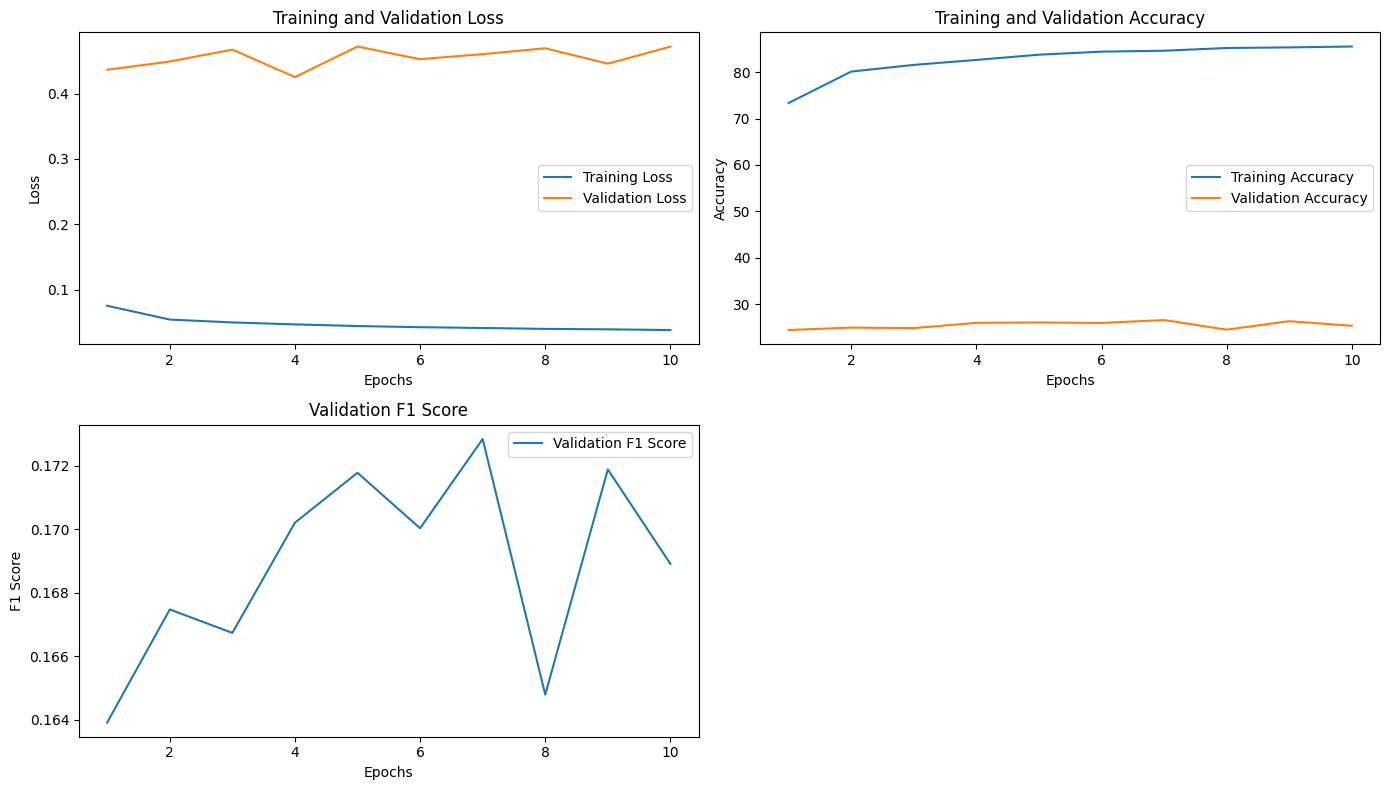

In [629]:
# Plotting the training and validation metrics
epochs = range(1, len(epoch_loss) + 1)

plt.figure(figsize=(14, 8))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs, epoch_loss, label='Training Loss')
plt.plot(epochs, epoch_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, epoch_train_acc, label='Training Accuracy')
plt.plot(epochs, epoch_val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs, epoch_val_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

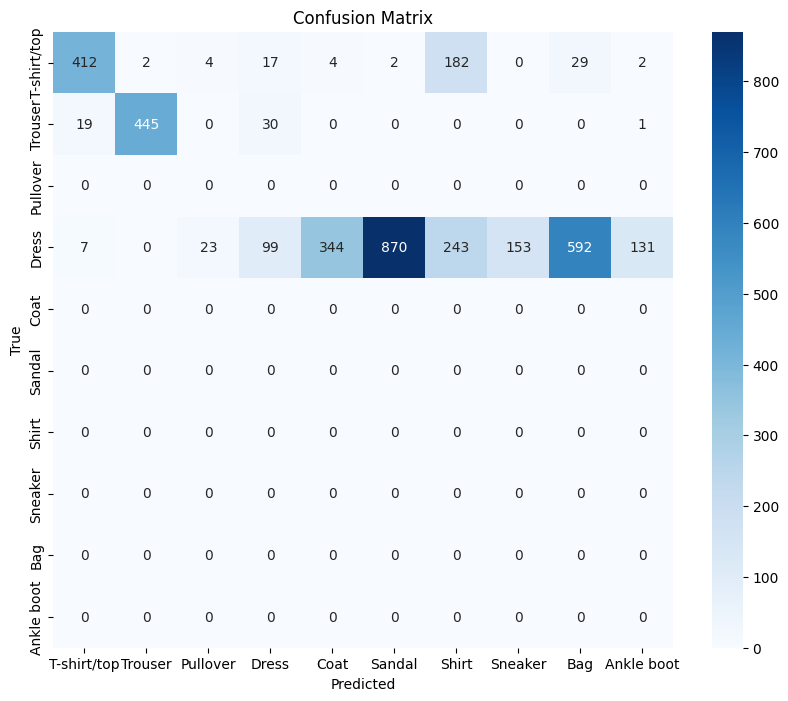

In [630]:
# Predict the classes for the test data
y_pred = selected_model.predict(test_data)
y_true_one_hot = np.eye(10)[test_labels]
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_true_one_hot, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes,predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()